In [15]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

torch.cuda.is_available() 

random_image = torch.randn(1, 3,224,224, dtype=torch.float).to(device)


Using device cpu


In [13]:
# Plot for VGG11, VGG11 with batch normalization, ResNet18, ResNet34, DenseNet121 and MobileNet-v3-Small

pretrained_models = [models.vgg11(weights='DEFAULT'), models.vgg11_bn(weights='DEFAULT'), models.resnet18(weights='DEFAULT')\
          , models.resnet34(weights='DEFAULT'), models.densenet121(weights='DEFAULT'), models.mobilenet_v3_small(weights='DEFAULT')]

In [14]:
params_list = []
inference_speed = []


for model in pretrained_models:
  model.to(device)
  model.eval()
  with torch.no_grad():
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    number_of_params = sum([np.prod(p.size()) for p in model_parameters])

  params_list.append(number_of_params)

  start_time = torch.cuda.Event(enable_timing=True)
  end_time = torch.cuda.Event(enable_timing=True)
  repetitions = 100
  timings=np.zeros((repetitions,1))

  for i in range(10):
      warm_up = model(random_image)
  with torch.no_grad():
      for repetition in range(repetitions):
          start_time.record()
          y_hat = model(random_image)
          end_time.record()
          # WAIT FOR GPU SYNC
          torch.cuda.synchronize()
          curr_time = start_time.elapsed_time(end_time)
          timings[repetition] = curr_time
  mean_syn = np.sum(timings) / repetitions
  inference_speed.append(mean_syn)
  std_syn = np.std(timings)
print(params_list)
print(inference_speed)


RuntimeError: Tried to instantiate dummy base class Event

ValueError: x and y must be the same size

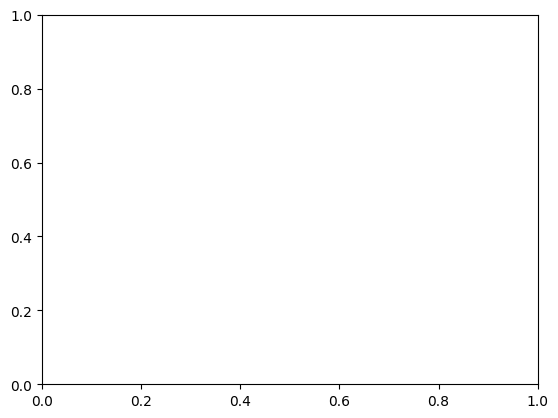

In [9]:
from matplotlib import axes
#plot inference over accuracy @5
model_names = ['VGG11', 'VGG11_bn', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet-v3-Small']
#All accuracies are reported @1
accuracy = [69.02, 70.37, 69.758, 73.314, 74.434,67.668]

plt.scatter(inference_speed, accuracy)
for i, name in enumerate(model_names): 
  xy = (inference_speed[i], accuracy[i])
  plt.annotate(name, xy)
plt.title('inference speed vs accuracy')
plt.show()



In [10]:
params_list = []
inference_speed_ = []


for model in pretrained_models:
  model.to(device)
  model.eval()
  with torch.no_grad():
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    number_of_params = sum([np.prod(p.size()) for p in model_parameters])

  params_list.append(number_of_params)

  start_time,end_time= torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  repetitions = 100
  timings=np.zeros((repetitions,1))

  for i in range(10):
      warm_up = model(random_image)
      for repetition in range(repetitions):
          start_time.record()
          y_hat = model(random_image)
          end_time.record()
          # WAIT FOR GPU SYNC
          torch.cuda.synchronize()
          curr_time = start_time.elapsed_time(end_time)
          timings[repetition] = curr_time
  mean_syn = np.sum(timings) / repetitions
  inference_speed_.append(mean_syn)
  std_syn = np.std(timings)
print(params_list)
print(inference_speed)

RuntimeError: Tried to instantiate dummy base class Event

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (0,).

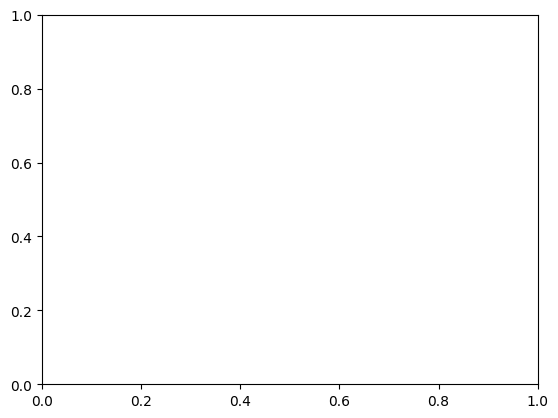

In [11]:
model_names = ['VGG11', 'VGG11_bn', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet-v3-Small']
X_axis = np.arange(len(model_names))

plt.bar(X_axis - 0.2, inference_speed , 0.4, label="No grad")
plt.bar(X_axis + 0.2, inference_speed_, 0.4,label="With grad")

  
plt.xticks(X_axis, model_names)
plt.xlabel("Models")
plt.ylabel("Inference time")
plt.title("Inference time used with/without grad")

plt.legend()
plt.show()

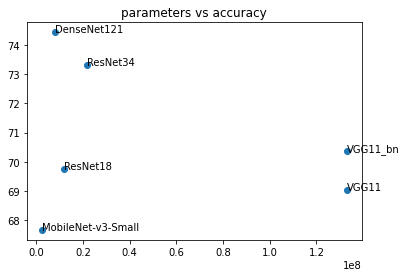

In [7]:
#plot inference over parameters 

plt.scatter(params_list ,accuracy)
for i, name in enumerate(model_names): 
  xy = (params_list[i], accuracy[i])
  plt.annotate(name, xy)
plt.title('parameters vs accuracy')
plt.show()


In [8]:
#plot inference over RAM usage with vs without no-grad 

#function with no grad
mem_no_grad = []
random_image_64 = torch.randn(64, 3,224,224).to(device)
for model in pretrained_models:
  with torch.no_grad():
      model.to(device)
      model.eval()
      y_hat = model(random_image_64)
      mem_no_grad.append(torch.cuda.memory_allocated()/1000000)
      torch.cuda.empty_cache()
  del model



In [9]:
#from torch.nn.modules.container import ModuleList
#import tqdm
#plot inference over RAM usage with vs without no-grad 

#function with grad
mem_with_grad = []
random_image_64 = torch.randn(64, 3,224,224).to(device)
for model in pretrained_models:
  print(f'Evaluating {model.__class__}...')
  model.to(device)
  model.eval()
  warm_up = model(random_image)
  mem_with_grad.append(torch.cuda.memory_allocated()/1000000)
  del model 


Evaluating <class 'torchvision.models.vgg.VGG'>...
Evaluating <class 'torchvision.models.vgg.VGG'>...
Evaluating <class 'torchvision.models.resnet.ResNet'>...
Evaluating <class 'torchvision.models.resnet.ResNet'>...
Evaluating <class 'torchvision.models.densenet.DenseNet'>...
Evaluating <class 'torchvision.models.mobilenetv3.MobileNetV3'>...


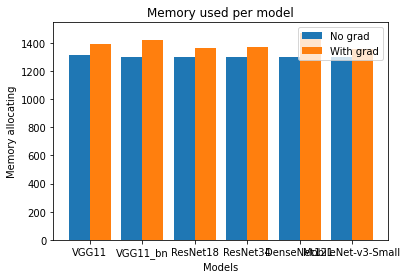

In [10]:
model_names = ['VGG11', 'VGG11_bn', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet-v3-Small']
X_axis = np.arange(len(model_names))

plt.bar(X_axis - 0.2, mem_no_grad, 0.4, label="No grad")
plt.bar(X_axis + 0.2, mem_with_grad, 0.4, label="With grad")

  
plt.xticks(X_axis, model_names)
plt.xlabel("Models")
plt.ylabel("Memory allocating")
plt.title("Memory used per model")
plt.legend()
plt.show()